# Exercise II - Predictive Analysis - Regression (Week 5) 

Housing in London - Finding Associations & Predicting Continuous Quantities

This exercise focuses on conducting predictive analysis (numerical and categorical) on a new dataset based on the content taught in Week 5 - Regression

### Dataset: Prep (Data Cleaning) & Overview

In [52]:
import pandas as pd
import numpy as np
# for data visualisation, plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# for colormap
from matplotlib import colormaps 
# for ml
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [53]:
# not use scientific notation for numbers (e.g 1.003767687e-12)
pd.set_option('display.float_format','{:.5f}'.format)
np.set_printoptions(suppress=True)

Dataset used for this exercise is from [Kaggle - Housing in London](https://www.kaggle.com/datasets/justinas/housing-in-london) by JUSTINAS CIRTAUTAS. It is centered around the housing market of London with a lot of additional relevant data (e.g., population size, mean salary)

In [54]:
# https://www.kaggle.com/datasets/justinas/housing-in-london
# split by borough, remove columns splited by other geographical regions to avoid duplications
# salary, population per year
df_yearly = pd.read_csv("./data/housing_in_london_yearly_variables.csv")
df_yearly = df_yearly[df_yearly['borough_flag'] == 1]

# avg. housing price per month
df_monthly = pd.read_csv("./data/housing_in_london_monthly_variables.csv")
df_monthly = df_monthly[df_monthly['borough_flag'] == 1]

In [55]:
df_yearly = df_yearly.drop('borough_flag', axis=1)
df_monthly = df_monthly.drop('borough_flag', axis=1)

In [56]:
# convert date to year
df_yearly['date'] = pd.to_datetime(df_yearly['date'])
df_yearly['year'] = df_yearly['date'].dt.year
df_yearly['date'] = df_yearly['year']

df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_monthly['year'] = df_monthly['date'].dt.year
df_monthly['date'] = df_monthly['year']

In [57]:
avg_price_per_year = df_monthly.groupby(['date', 'area']).agg({'average_price': 'mean'}).reset_index()

In [58]:
avg_price_per_year

,date,area,average_price
0,1995,barking and dagenham,51818.00000
1,1995,barnet,91792.50000
2,1995,bexley,64291.58333
3,1995,brent,73029.91667
4,1995,bromley,81967.25000
...,...,...,...
853,2020,sutton,371626.00000
854,2020,tower hamlets,450669.00000
855,2020,waltham forest,452299.00000
856,2020,wandsworth,610256.00000


In [59]:
# merge dataets on 'date' and 'area'
# code inherited from week 2 - cleaning data
# anything with no match gets dropped so this removes all of our non state entries as well

df = pd.merge(df_yearly, avg_price_per_year, how='left', left_on=['date', 'area'], right_on=['date', 'area'])

In [60]:
df = df.drop(['life_satisfaction', 'recycling_pct', 'number_of_jobs', 'area_size', 'no_of_houses', 'year'], axis=1)
order = ['code', 'date', 'area', 'average_price', 'median_salary', 'mean_salary', 'population_size']
df = df[order]

In [61]:
df

,code,date,area,average_price,median_salary,mean_salary,population_size
0,E09000001,1999,city of london,171300.08333,33020.00000,48922,6581.00000
1,E09000002,1999,barking and dagenham,65320.83333,21480.00000,23620,162444.00000
2,E09000003,1999,barnet,136004.41667,19568.00000,23128,313469.00000
3,E09000004,1999,bexley,86777.66667,18621.00000,21386,217458.00000
4,E09000005,1999,brent,112157.41667,18532.00000,20911,260317.00000
...,...,...,...,...,...,...,...
688,E09000029,2019,sutton,372501.08333,32947.00000,37392,NaN
689,E09000030,2019,tower hamlets,439009.58333,46142.00000,69434,NaN
690,E09000031,2019,waltham forest,430663.58333,30718.00000,33119,NaN
691,E09000032,2019,wandsworth,588672.41667,34168.00000,39617,NaN


In [62]:
columns_to_convert = ['average_price', 'median_salary', 'mean_salary', 'population_size']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [63]:
# any missing values?
df.isnull().sum()

code                0
date                0
area                0
average_price       0
median_salary      10
mean_salary         7
population_size    33
dtype: int64

In [64]:
df = df.dropna()

In [65]:
original_df = df.copy()

In [66]:
df

,code,date,area,average_price,median_salary,mean_salary,population_size
0,E09000001,1999,city of london,171300.08333,33020.00000,48922.00000,6581.00000
1,E09000002,1999,barking and dagenham,65320.83333,21480.00000,23620.00000,162444.00000
2,E09000003,1999,barnet,136004.41667,19568.00000,23128.00000,313469.00000
3,E09000004,1999,bexley,86777.66667,18621.00000,21386.00000,217458.00000
4,E09000005,1999,brent,112157.41667,18532.00000,20911.00000,260317.00000
...,...,...,...,...,...,...,...
655,E09000029,2018,sutton,379262.58333,28853.00000,32442.00000,204525.00000
656,E09000030,2018,tower hamlets,446500.41667,49237.00000,69806.00000,317705.00000
657,E09000031,2018,waltham forest,440859.41667,30298.00000,32875.00000,276700.00000
658,E09000032,2018,wandsworth,596649.16667,34501.00000,45317.00000,326474.00000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 645 entries, 0 to 659
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             645 non-null    object 
 1   date             645 non-null    int32  
 2   area             645 non-null    object 
 3   average_price    645 non-null    float64
 4   median_salary    645 non-null    float64
 5   mean_salary      645 non-null    float64
 6   population_size  645 non-null    float64
dtypes: float64(4), int32(1), object(2)
memory usage: 37.8+ KB


In [68]:
df.describe

<bound method NDFrame.describe of           code  date                  area  average_price  median_salary  \
0    E09000001  1999        city of london   171300.08333    33020.00000   
1    E09000002  1999  barking and dagenham    65320.83333    21480.00000   
2    E09000003  1999                barnet   136004.41667    19568.00000   
3    E09000004  1999                bexley    86777.66667    18621.00000   
4    E09000005  1999                 brent   112157.41667    18532.00000   
..         ...   ...                   ...            ...            ...   
655  E09000029  2018                sutton   379262.58333    28853.00000   
656  E09000030  2018         tower hamlets   446500.41667    49237.00000   
657  E09000031  2018        waltham forest   440859.41667    30298.00000   
658  E09000032  2018            wandsworth   596649.16667    34501.00000   
659  E09000033  2018           westminster  1020025.50000    43015.00000   

     mean_salary  population_size  
0    48922.00000 

In [69]:
df['area'].unique()

array(['city of london', 'barking and dagenham', 'barnet', 'bexley',
       'brent', 'bromley', 'camden', 'croydon', 'ealing', 'enfield',
       'greenwich', 'hackney', 'hammersmith and fulham', 'haringey',
       'harrow', 'havering', 'hillingdon', 'hounslow', 'islington',
       'kensington and chelsea', 'kingston upon thames', 'lambeth',
       'lewisham', 'merton', 'newham', 'redbridge',
       'richmond upon thames', 'southwark', 'sutton', 'tower hamlets',
       'waltham forest', 'wandsworth', 'westminster'], dtype=object)

33 areas in total, matches the total number of London borough (32 local authority districts + the City of London) https://en.wikipedia.org/wiki/London_boroughs

In [70]:
df['date'].unique()

array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int32)

In [71]:
df['date'].value_counts()

date
1999    33
2007    33
2017    33
2015    33
2014    33
2012    33
2011    33
2010    33
2009    33
2005    33
2003    33
2002    33
2008    32
2006    32
2013    32
2001    32
2000    31
2016    31
2004    30
2018    29
Name: count, dtype: int64

### Correlation 

Use **correlation** to investigate how much of relationship there is between two variables. 

#### Mean_Salary vs. Average_Price - a moderate positive correlation

Based on the following plots, We could say there is probably positive correlation between the ``Mean Salary`` and ``Average Housing Price``. The area with higher mean salary also tend to have a higher avg. housing price.

A correlation coefficient (r) of 0.468 indicates a moderate positive linear relationship between ``Mean Salary`` and ``Average Housing Price``.

To make a model of this relationship bewteen ``Mean Salary`` and ``Average Housing Price``:
- Avg. Housing Price = 7.53 * Mean Salary + 52089.7 + error

A p-value of 1.5186561799852647e-36 is an extremely small value, implying strong evidence against the null hypothesis - meaning this relationship is in fact the case for  ``Mean Salary`` and ``Average Housing Price``.

In [72]:
df

,code,date,area,average_price,median_salary,mean_salary,population_size
0,E09000001,1999,city of london,171300.08333,33020.00000,48922.00000,6581.00000
1,E09000002,1999,barking and dagenham,65320.83333,21480.00000,23620.00000,162444.00000
2,E09000003,1999,barnet,136004.41667,19568.00000,23128.00000,313469.00000
3,E09000004,1999,bexley,86777.66667,18621.00000,21386.00000,217458.00000
4,E09000005,1999,brent,112157.41667,18532.00000,20911.00000,260317.00000
...,...,...,...,...,...,...,...
655,E09000029,2018,sutton,379262.58333,28853.00000,32442.00000,204525.00000
656,E09000030,2018,tower hamlets,446500.41667,49237.00000,69806.00000,317705.00000
657,E09000031,2018,waltham forest,440859.41667,30298.00000,32875.00000,276700.00000
658,E09000032,2018,wandsworth,596649.16667,34501.00000,45317.00000,326474.00000


(7.5272665, 52089.70510250388)

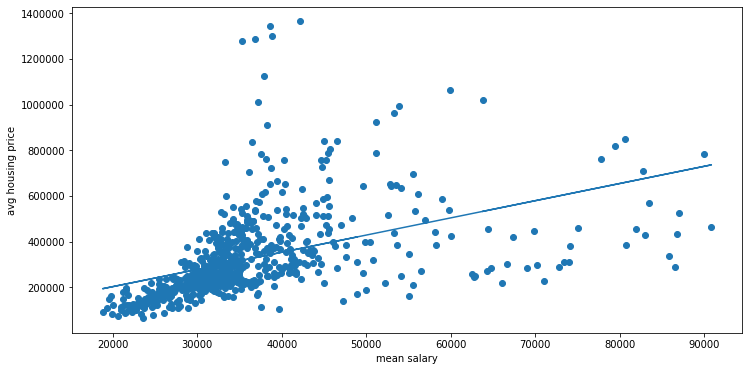

In [73]:
data = df[["mean_salary", "average_price"]].values
x = data[:, 0]
y = data[:, 1]

def plot_scatter(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style='plain')
    return ax

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]

ax = plot_scatter(x, y, "mean salary", "avg housing price")
ax.plot(x, model_y)
slope, intercept

In [74]:
r, p = stats.pearsonr(x,y)
r

0.4687515375935415

In [75]:
p

1.51865617998509e-36

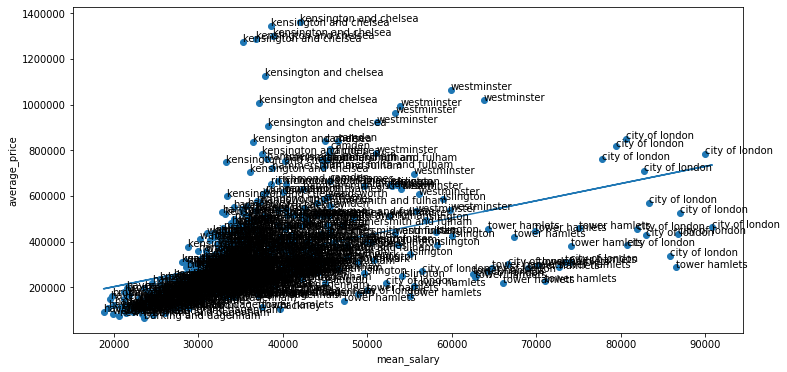

In [76]:
def plot_scatter(x,y,xlabel,ylabel,annotate=True):
    fig,ax = plt.subplots(figsize = (12,6))
    ax.scatter(x,y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style='plain')
    if annotate:
        annotations = df["area"].values
        for i, label in enumerate(annotations):
            ax.annotate(label, (x[i], y[i]))
    return ax

ax = plot_scatter(x,y,"mean_salary","average_price")
ax.plot(x, model_y)

However - it is quite obvious that the dataset has some extreme values for housing prices, particularly around 40,000 mean salary -  appear to be somewhat high compared to the rest of the data.

By annotating the data points, we can see that those `extreme` values belong to either `kensington and chelsea` or `westminster` areas, which makes sense as these areas are known for their high property values in London.

Will remove those 'outlisers' effect the relationshiop between the ``Mean Salary`` and ``Average Housing Price``?

#### Mean_Salary vs. Average_Price (without outliers)

In [77]:
# reference code found in: https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/
updated_df = df[(df['area'] != 'kensington and chelsea') & (df['area'] != 'westminster')]
updated_df

,code,date,area,average_price,median_salary,mean_salary,population_size
0,E09000001,1999,city of london,171300.08333,33020.00000,48922.00000,6581.00000
1,E09000002,1999,barking and dagenham,65320.83333,21480.00000,23620.00000,162444.00000
2,E09000003,1999,barnet,136004.41667,19568.00000,23128.00000,313469.00000
3,E09000004,1999,bexley,86777.66667,18621.00000,21386.00000,217458.00000
4,E09000005,1999,brent,112157.41667,18532.00000,20911.00000,260317.00000
...,...,...,...,...,...,...,...
654,E09000028,2018,southwark,504235.25000,39998.00000,48333.00000,317256.00000
655,E09000029,2018,sutton,379262.58333,28853.00000,32442.00000,204525.00000
656,E09000030,2018,tower hamlets,446500.41667,49237.00000,69806.00000,317705.00000
657,E09000031,2018,waltham forest,440859.41667,30298.00000,32875.00000,276700.00000


(6.5343666, 65883.89989560904)

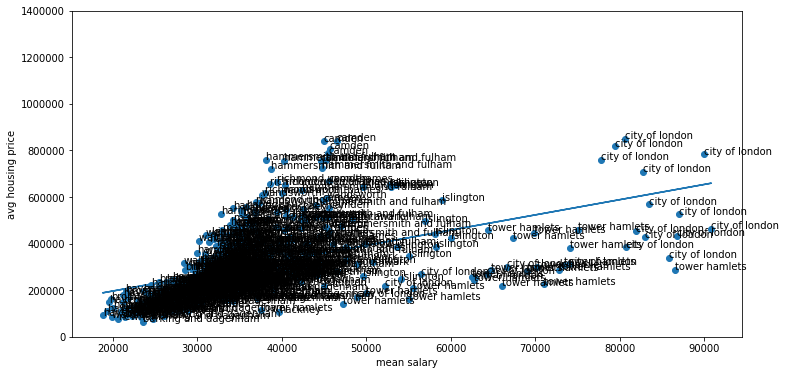

In [78]:
data = updated_df[["mean_salary", "average_price"]].values
x = data[:,0]
y = data[:,1]

def plot_scatter(x, y, xlabel, ylabel, annotate=True):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x,y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_ylim(0, 1400000) # set the same lim to see the changes
    ax.ticklabel_format(style='plain')
    if annotate:
        annotations = updated_df["area"].values
        for i, label in enumerate(annotations):
            ax.annotate(label, (x[i], y[i]))
    return ax

ax = plot_scatter(x, y, "mean salary", "avg housing price")

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]
ax.plot(x, model_y)
slope, intercept

In [79]:
r, p = stats.pearsonr(x,y)
r

0.5357820552624449

In [80]:
p

2.9914344915652167e-46

Based on the above plots, after removing data of 'kensington and chelsea' and 'westminster', there is a stronger positive correlation between the ``Mean Salary`` and ``Average Housing Price`` with a correlation coefficient (r) of 0.536 indicates a stronger positive linear relationship between ``Mean Salary`` and ``Average Housing Price`` compared to the original dataset.

But THIS IS NOT RIGHT - removing real data simply not help but would only hurt the model’s robustness in prediction

We might also just say that a linear correlation here isn’t going to be the appropriate choice for modelling the relationship as it fails to capture the relationship. Other modelling techniques such as regression need to be tested to see if they can better capture the underlying relationship.

#### Median_Salary vs. Average_Price - a moderate to strong positive correlation

This is also a positive correlation between the ``Median Salary`` and ``Average Housing Price``. A correlation coefficient (r) of 0.572 (0.679 without outlies) indicates a stronger positive linear relationship between ``Median Salary`` and ``Average Housing Price`` than the relationship between the ``Mean Salary`` and ``Average Housing Price``.

The model of the relationship bewteen the ``Median Salary`` and ``Average Housing Price``:
- Avg. Housing Price = 16.86669 * Median Salary -170146.76204597624 + error 

(16.86669, -170146.76204597612)

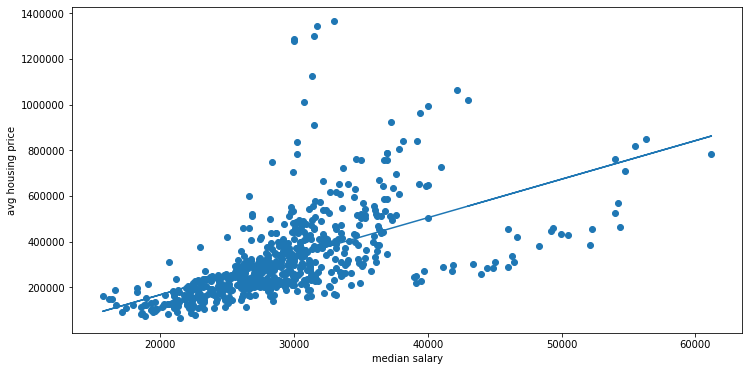

In [81]:
# df
data = df[["median_salary", "average_price"]].values
x = data[:, 0]
y = data[:, 1]

def plot_scatter(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style = 'plain')
    return ax

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]

ax = plot_scatter(x, y, "median salary", "avg housing price")
ax.plot(x, model_y)
slope, intercept

In [82]:
r, p = stats.pearsonr(x,y)
r

0.5717336102845672

In [83]:
p

2.957836588308593e-57

#### Population_size vs. Average_Price - a slight negative linear relationship / no relationship - NOT a good predictor

For the ``Pupulation Size`` and ``Average Housing Price``, while a correlation coefficient (r) of -0.13548447470395442 theoratically indicates a small tendency for the variables to move in opposite directions, the relationship overall is weak and might not be useful or significant for predictive modeling

(-0.3746311, 415543.3048599544)

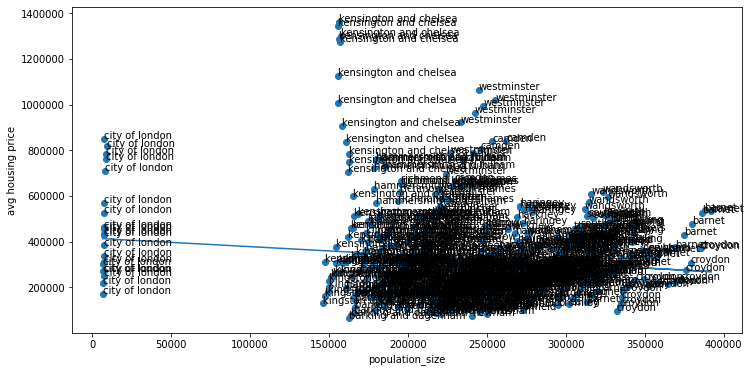

In [84]:
data = df[["population_size", "average_price"]].values
x = data[:, 0]
y = data[:, 1]

def plot_scatter(x, y, xlabel, ylabel, annotate=True):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style = 'plain')
    if annotate:
        annotations = df["area"].values
        for i, label in enumerate(annotations):
            ax.annotate(label, (x[i], y[i]))
    return ax

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]

ax = plot_scatter(x, y, "population_size", "avg housing price")
ax.plot(x, model_y)
slope, intercept

In [85]:
r, p = stats.pearsonr(x,y)
r

-0.13548447470395444

#### Date vs. Average_Price - a moderate to strong positive correlation

Based on the following plots, We could say there is probably positive correlation between the ``Date(Year)`` and ``Average Housing Price``. The avg. housing price is getting higher and higher each year.

A correlation coefficient (r) of 0.633 indicates a moderate to strong positive linear relationship between the ``Date(Year)`` and ``Average Housing Price``.

The model of the relationship bewteen ``Date(Year)`` and ``Average Housing Price``:
- Avg. Housing Price = 20961.79 * Year -41775959.51469805 + error

The extremely small p-value again implies strong evidence against the null hypothesis - meaning this relationship is in fact the case for  ``Date(Year)`` and ``Average Housing Price``.

By annotating the graph, we can also see that each year, the areas such as `kensington and chelsea` and `westminster` have the highest avg. housing price (much higher than other areas), while ``barking and dagenham`` seems to have the lowest avg. housing price each year. - I looked at it on Google Map and it's far away from the city of London, next to London City Airport, probably a good place to stay if work remotely?

(20961.79, -41775959.51469798)

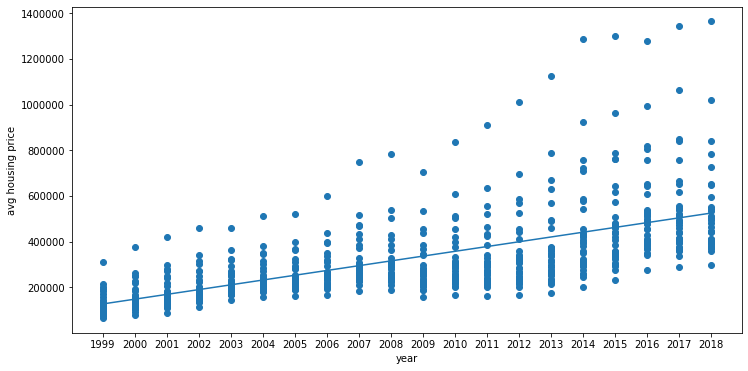

In [86]:
data = df[["date", "average_price"]].values
x = data[:, 0]
y = data[:, 1]

def plot_scatter(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x, y)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style = 'plain')
    return ax

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]

ax = plot_scatter(x, y, "year", "avg housing price")
ax.plot(x, model_y)
slope, intercept

In [87]:
r, p = stats.pearsonr(x,y)
r

0.633417679031275

In [88]:
p

1.2214773498513404e-73

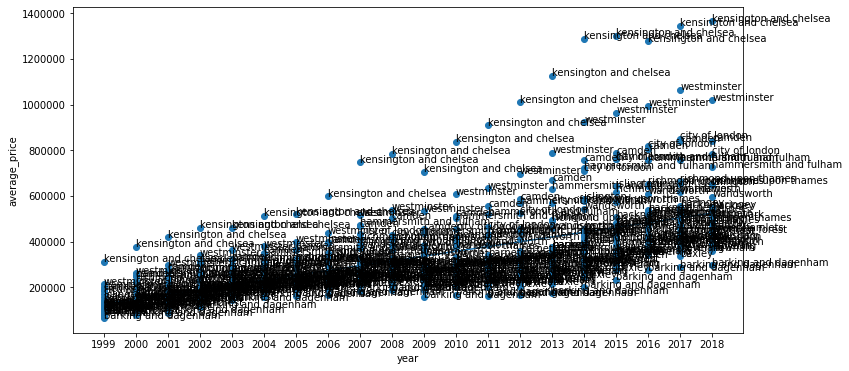

In [89]:
def plot_scatter(x,y,xlabel,ylabel,annotate=True):
    fig,ax = plt.subplots(figsize = (12,6))
    ax.scatter(x,y)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style='plain')
    if annotate:
        annotations = df["area"].values
        for i, label in enumerate(annotations):
            ax.annotate(label, (x[i], y[i]))
    return ax

ax = plot_scatter(x, y, "year", "average_price")
ax.plot(x, model_y)

### Regression (multiple variables)

##### Linear Regression - how date and population size affect housing price?

- based on the results, the model has a limited predictive capability, might not be suitable for prediction.

In [90]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

In [91]:
x = df[['median_salary','population_size']]
y = df['average_price'] 
regr = linear_model.LinearRegression()
regr.fit(x, y) 
print(regr.coef_, regr.intercept_, regr.score(x, y)) 

[16.93660629  0.02596908] -178458.92072258325 0.326961907471254


/Users/irenex/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


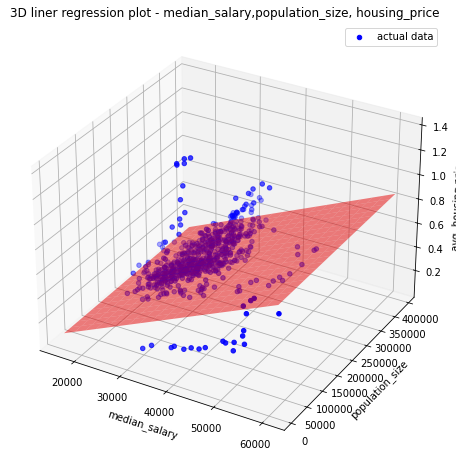

In [114]:
# 3D Plotting

# reference code: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

# plot data (actual ones in dataset)
# reference code: https://stackoverflow.com/questions/1985856/how-to-make-a-3d-scatter-plot
x = df[['median_salary','population_size']]
y = df['average_price'] 
ax.scatter(df['median_salary'], df['population_size'], y, color='blue', marker = 'o', label='actual data')

# plot regression surface
# code initially adapted from ChatGPT with a prompt - how to plot regression surface in 3D linear regression plot
# modification made according to the dataset and other external resources
# reference code: https://www.kaggle.com/code/zhehaoz/stat-504-3d-plot-regression-surface-python
# create a meshgrid for the feature ranges
x_range = np.linspace(df['median_salary'].min(), df['median_salary'].max(), 20)
y_range = np.linspace(df['population_size'].min(), df['population_size'].max(), 20)
x, y = np.meshgrid(x_range, y_range)
# flatten the grid for prediction
predict_input = np.vstack([x.ravel(), y.ravel()]).T
z = regr.predict(predict_input)
z = z.reshape(x.shape)
ax.plot_surface(x, y, z, color='red', alpha=0.5, rstride=1, cstride=1, edgecolor='none')

ax.set_xlabel('median_salary')
ax.set_ylabel('population_size')
ax.set_zlabel('avg. housing price')
ax.set_title('3D liner regression plot - median_salary,population_size, housing_price')
plt.legend()
plt.show()

In [ ]:
predict_value = regr.predict([[40000, 200000]])
predict_value

/Users/irenex/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([504199.14722131])

In [ ]:
504199.14722131 / 40000

12.60497868053275

Based on the above, if we have an area has a median salary of £40,000 and a population size of 200,000, we could expect an average housing price of £504,199. (so that an individual would need to work approximately 13 years to afford a house, without factoring in any living expenses....)

In [ ]:
pred = regr.predict(x)

In [ ]:
# evaluation of the model
# reference code: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
r2 = r2_score(y, pred)
print("r squared:", r2)

mae = mean_absolute_error(y, pred)
print("mean absolute error:", mae)

mse = mean_squared_error(y, pred)
print("mean_squared_error:", mse)

rmse = np.sqrt(mse)
print("root mean squared error:", rmse)

r squared: 0.326961907471254
mean absolute error: 97425.31480318085
mean_squared_error: 24206956360.626804
root mean squared error: 155585.84884438175


#### Polynomial Regression

Using only data for the kensington and chelsea:

- In the case of `date` & `avg. housing price` - a linear model already has a very good fit to the data (r2 = 0.9648334724524961)
- In the case of `mean salary` & `avg. housing price` - the best r2 I can get is to set the number of degrees of 5 or 6, which gives a r2 around 0.59; I can get a higher r2 if I just increase the number of degrees to a very large number, but then the fitted line doesn't make more sence, which I assume it has no capabilities to make meaningful predictions as the model is clearly overfitting. 

What can I do to avoid overfitting, and find a balance bewteen model complexity, fit, and generalisability?

In [ ]:
df_kc = df[df['area'] == 'kensington and chelsea']

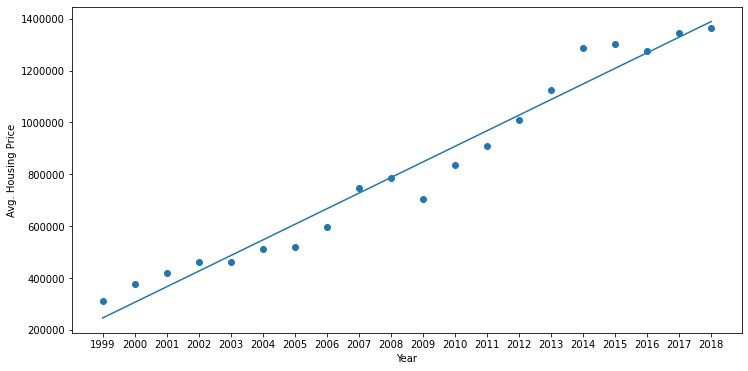

In [ ]:
# date & avg. housing price
# for kensington abd chelsea
# first try to plot linear model
data = df_kc[["date","average_price"]].values
x = data[:,0]
y = data[:,1]

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]
ax = plot_scatter(x, y, "Year", "Avg. Housing Price", False)
ax.plot(x, model_y)

 
6.018e+04 x - 1.2e+08


r2 = 0.9648334724524961


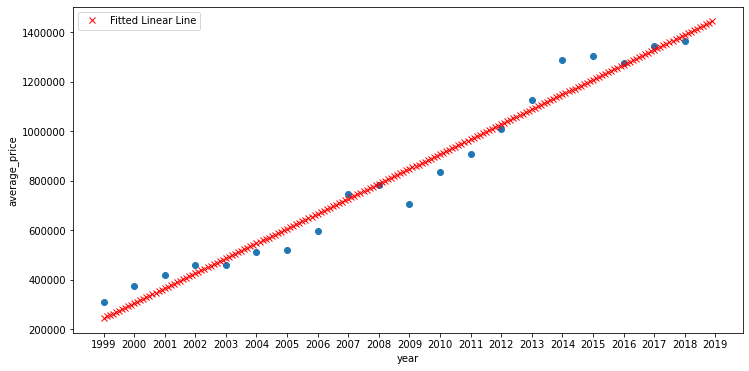

In [ ]:
def plot_scatter(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

data = df_kc[["date","average_price"]].values
x = data[:, 0]
y = data[:, 1]

# fits the data within a polynomial function - ``np.polyfit()``
num_degrees = 1
poly_model = np.poly1d(np.polyfit(x, y, num_degrees))

# get r2 score
r2 = r2_score(y, poly_model(x))

# plot
ax = plot_scatter(x, y, "year", "average_price")
model_x = np.arange(np.min(x), np.max(x)+1, 0.1)
model_y = poly_model(model_x)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.plot(model_x, model_y, "rx", label="Fitted Linear Line")
ax.legend()

plt.ticklabel_format(style='plain', axis='y')

print(poly_model)
print("\n")
print("r2 =",r2)

Based on the above graph and data, it appears that the average housing price in Kensington and Chelsea will likely continue to rise, which is not actually the case. According to data from [HM Land Registry Open Data](https://landregistry.data.gov.uk/app/ukhpi/browse?from=1999-01-01&location=http%3A%2F%2Flandregistry.data.gov.uk%2Fid%2Fregion%2Fkensington-and-chelsea&to=2024-02-01&lang=en), covering the period from 1999 to 2024, the average housing price has been fluctuating rather than showing a consistent upward trend since 2015. While the graph validates the growth observed between 1999 and 2019, it fails to accurately predict future prices. This highlights the **limitation of relying solely on past performance for making predictions.**

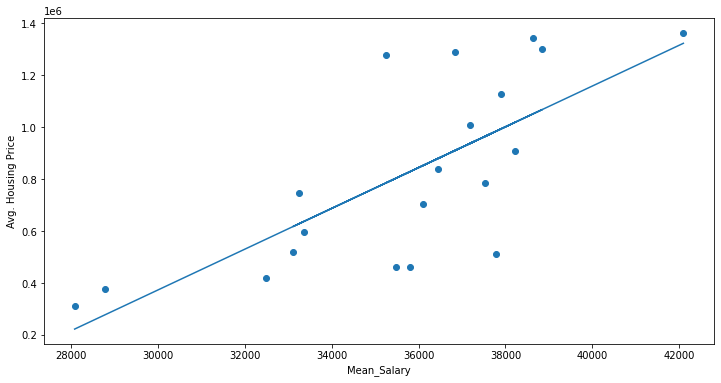

In [ ]:
# mean salary & avg. housing price
# for westminster
data = df_kc[["mean_salary", "average_price"]].values
x = data[:,0]
y = data[:,1]

slope, intercept, r, p, std_err = stats.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]
ax = plot_scatter(x, y, "Mean_Salary", "Avg. Housing Price")
ax.plot(x, model_y)

            6             5             4           3        2
-5.121e-17 x + 1.057e-11 x - 9.045e-07 x + 0.04112 x - 1047 x + 1.417e+07 x - 7.955e+10


r2 = 0.5976975874425059


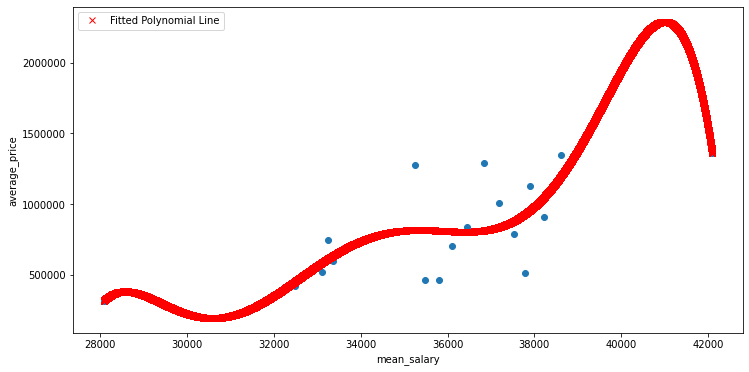

In [ ]:
def plot_scatter(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

data = df_kc[["mean_salary", "average_price"]].values
x = data[:,0]
y = data[:,1]

# fits the data within a polynomial function - ``np.polyfit()``
num_degrees = 6
poly_model = np.poly1d(np.polyfit(x, y, num_degrees))

# get r2 score
r2 = r2_score(y, poly_model(x))

# plot
ax = plot_scatter(x, y, "mean_salary", "average_price")
model_x = np.arange(np.min(x), np.max(x)+1, 0.1)
model_y = poly_model(model_x)
ax.plot(model_x, model_y, "rx", label="Fitted Polynomial Line")
ax.legend()

plt.ticklabel_format(style='plain', axis='y')

print(poly_model)
print("\n")
print("r2 =",r2)

### Code References

[1] https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/

[2] https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy

[3] https://www.kaggle.com/code/zhehaoz/stat-504-3d-plot-regression-surface-python

[4] https://stackoverflow.com/questions/1985856/how-to-make-a-3d-scatter-plot

[5] https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

[6] https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

[7] https://en.wikipedia.org/wiki/London_boroughs

*ChatGPT 3.5 was used in this exercise for helping plotting regression surface and some proofreadings.